## Module

In [1]:
import os, sys, urllib, warnings, errno, logging, time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

import torch.nn as nn

In [2]:
sys.path.append('')

In [3]:
from base_multibary import *
from multi_barycenter import *
from util import load_data, plot_images, create_deep_density_cd, create_deep_tree_cd, wrap_transform
from metrics import *
from classifier import *

from ddl.base import (CompositeDestructor, DestructorMixin, create_inverse_transformer, 
                      BoundaryWarning, DataConversionWarning, IdentityDestructor)
from ddl.independent import IndependentDensity, IndependentDestructor, IndependentInverseCdf
from ddl.linear import LinearProjector
from ddl.univariate import HistogramUnivariateDensity, ScipyUnivariateDensity
from ddl.deep import DeepDestructor
from ddl.linear import LinearProjector, RandomOrthogonalEstimator, BestLinearReconstructionDestructor
from weakflow import *

warnings.simplefilter('ignore', BoundaryWarning) # Ignore boundary warnings from ddl
warnings.simplefilter('ignore', DataConversionWarning) # Ignore data conversion warnings from ddl

## Prepare the data

In [4]:
class_list = [0,1,2]
#class_list = [0,1]
n_class = len(class_list)

## Train the model

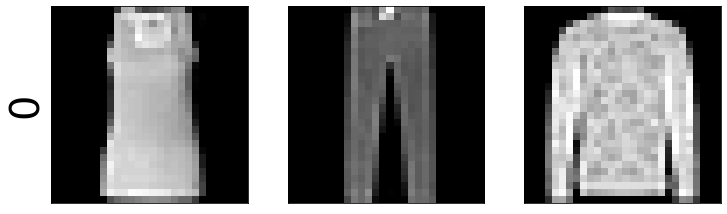

In [5]:
X = torch.load('')
y = torch.load('')
n_samples_list = [len(np.nonzero(y==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)
idx = [n_samples*i for i in class_list]
plot_images(1-X[idx, :], ylabel='0')

In [6]:
cd_dict = dict()

In [7]:
start = time.time()
cd_gb = wrap_transform(GaussianBaryMultiClassifierDestructor())
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    cd_gb.fit_transform(X, y)
print(f'fitting time: {time.time()-start} s')
cd_dict['GB'] = cd_gb
del(cd_gb)

fitting time: 278.46626830101013 s


In [8]:
start = time.time()
cd_nb = wrap_transform(NaiveBaryMultiClassifierDestructor())
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    cd_nb.fit_transform(X, y)
print(f'fitting time: {time.time()-start} s')
cd_dict['NB'] = cd_nb
del(cd_nb)

fitting time: 25.81114172935486 s


In [9]:
start = time.time()
cd_gbnb = wrap_transform(CompositeDestructor([
    GaussianBaryMultiClassifierDestructor(),
    NaiveBaryMultiClassifierDestructor(),
]))
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    cd_gbnb.fit_transform(X, y)
print(f'fitting time: {time.time()-start} s')
cd_dict['GBNB'] = cd_gbnb
del(cd_gbnb)

fitting time: 295.74636006355286 s


In [ ]:
start = time.time()

cd_swd_nb = MSWDBaryClassifierDestructor()
n_layers = 100
ndim = 10

# add an inverse normal CDF
Z = cd_swd_nb.initialize(X,y)

# add mSWD-NB layers
for i in range(n_layers):
    if i%10 == 0:
        print(i)
    cd_swd_nb, Z = add_one_layer(cd_swd_nb, Z, y, 'nb', ndim=ndim )

# add a normal CDF
Z = cd_swd_nb.end(Z, y)
del(Z)
print(f'fitting time: {time.time()-start} s')
cd_dict['mSWD-NB'] = cd_swd_nb
del(cd_swd_nb)    

In [11]:
start = time.time()
cd_dd = create_deep_density_cd(n_canonical_destructors=10)
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    cd_dd.fit_transform(X, y)
print(f'fitting time: {time.time()-start} s')
cd_dict['DD'] = cd_dd
del(cd_dd)    

fitting time: 447.7430489063263 s


## Evaluation

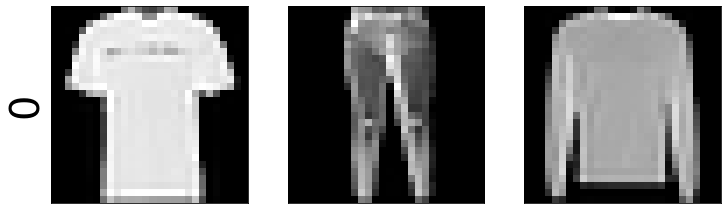

In [12]:
X_cnn = torch.load('')
y_cnn = torch.load('')
X_eval = torch.load('')
y_eval = torch.load('')

X = np.concatenate((X_cnn, X_eval))
y = np.concatenate((y_cnn, y_eval))

n_samples_list = [len(np.nonzero(y==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)
n_split = 1500

idx = [n_split*i for i in class_list]
plot_images(1-X[idx, :], ylabel='0')

### Flipping of digits

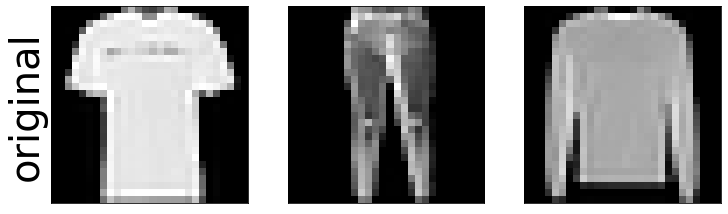

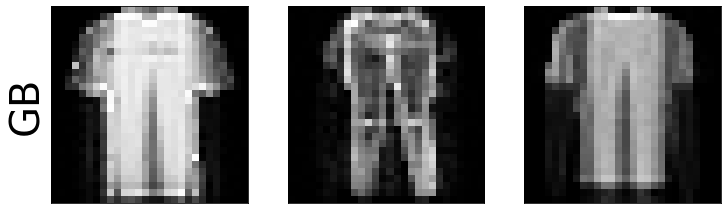

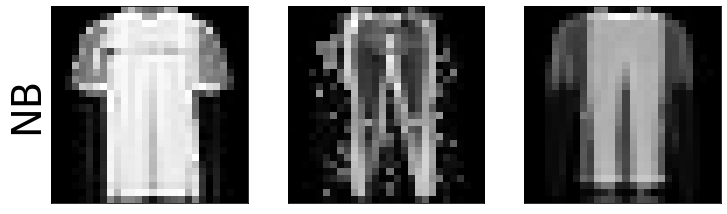

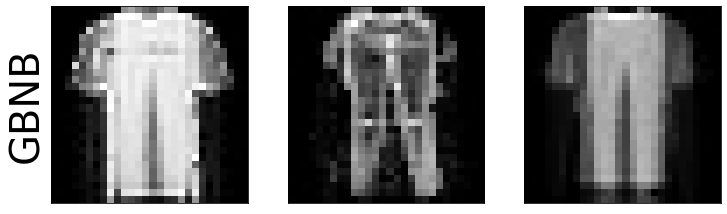

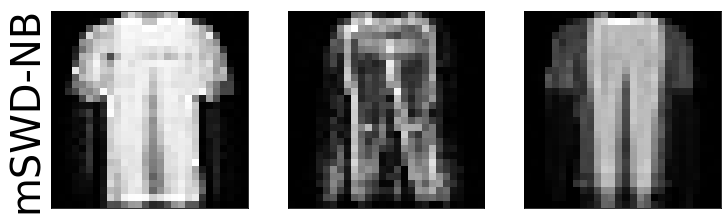

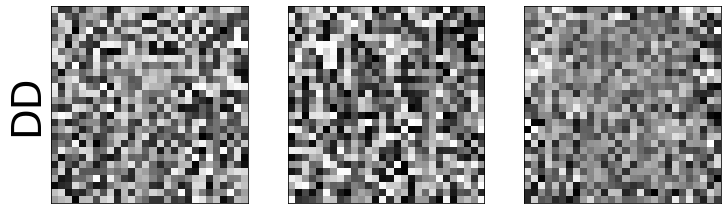

In [13]:
Z_dict = dict()
idx = []
for i in class_list:
    idx.append(n_split*i)
plot_images(1-X[idx, :], ylabel=f'original')
plt.show()

for key, cd in cd_dict.items():
    if key in ['GB', 'NB', 'GBNB','DD']:
        Z_temp = cd.transform(X, y)
    else:
        Z_temp = cd(X, y)

    Z_dict[key] = Z_temp
    plot_images(1-Z_temp[idx, :], ylabel=key)
    plt.show()


In [14]:
def gen_plot(cd_dict, key, X, y, path, idx=0, show=False):
    print(key)
    input_size=(1, 28, 28)
    vmin=-1
    vmax=0
    cd = cd_dict[key]
    fig,axs = plt.subplots(n_class,n_class,figsize=(12,12))
    for i,l in enumerate(class_list):
        for j,m in enumerate(class_list):
            X_temp = X[np.nonzero(y==l)[0]][idx,:].reshape(1,-1)
            if key in ['GB', 'NB', 'GBNB','DD']:
                Z_temp = cd.transform(X_temp, np.array([l]))
            else:
                Z_temp = cd(X_temp, np.array([l]))
            if key in ['GB', 'NB', 'GBNB','DD']:
                Xflip_temp = cd.inverse_transform(Z_temp, np.array([m]))
            else:
                Xflip_temp = cd.inverse(Z_temp, np.array([m]))
            axs[j,i].imshow((Xflip_temp-1).reshape(*input_size[1:]), cmap='gray', vmin=vmin, vmax=vmax)
            axs[j,i].set_xticks([])
            axs[j,i].set_yticks([])     
    plt.savefig('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/figures'+ path, bbox_inches='tight')
    plt.show()


In [15]:
def gen_plot(cd_dict, key, X, y, path, idx=0, show=False):
    print(key)
    input_size=(1, 28, 28)
    vmin=-1
    vmax=0
    cd = cd_dict[key]
    fig,axs = plt.subplots(n_class,n_class+2,figsize=(14.4,12))
    for i,l in enumerate(class_list):
        X_temp = X[np.nonzero(y==l)[0]][idx,:].reshape(1,-1)
        axs[i,0].imshow((X_temp-1).reshape(*input_size[1:]), cmap='gray', vmin=vmin, vmax=vmax)
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])   
        
        if key in ['GB', 'NB', 'GBNB','DD']:
            Z_temp = cd.transform(X_temp, np.array([l]))
        else:
            Z_temp = cd(X_temp, np.array([l]))
        axs[i,1].imshow((Z_temp-1).reshape(*input_size[1:]), cmap='gray', vmin=vmin, vmax=vmax)
        axs[i,1].set_xticks([])
        axs[i,1].set_yticks([]) 
        
        for j,m in enumerate(class_list):
            if key in ['GB', 'NB', 'GBNB','DD']:
                Xflip_temp = cd.inverse_transform(Z_temp, np.array([m]))
            else:
                Xflip_temp = cd.inverse(Z_temp, np.array([m]))
            axs[i,j+2].imshow((Xflip_temp-1).reshape(*input_size[1:]), cmap='gray', vmin=vmin, vmax=vmax)
            axs[i,j+2].set_xticks([])
            axs[i,j+2].set_yticks([])     
    axs[2,0].set_xlabel('real', fontsize=15)  
    axs[2,1].set_xlabel('shared', fontsize=15) 
    for k in class_list:
        axs[2,k+2].set_xlabel(f'{k}\'', fontsize=15) 
    plt.savefig(''+ path, bbox_inches='tight')
    plt.show()


NB


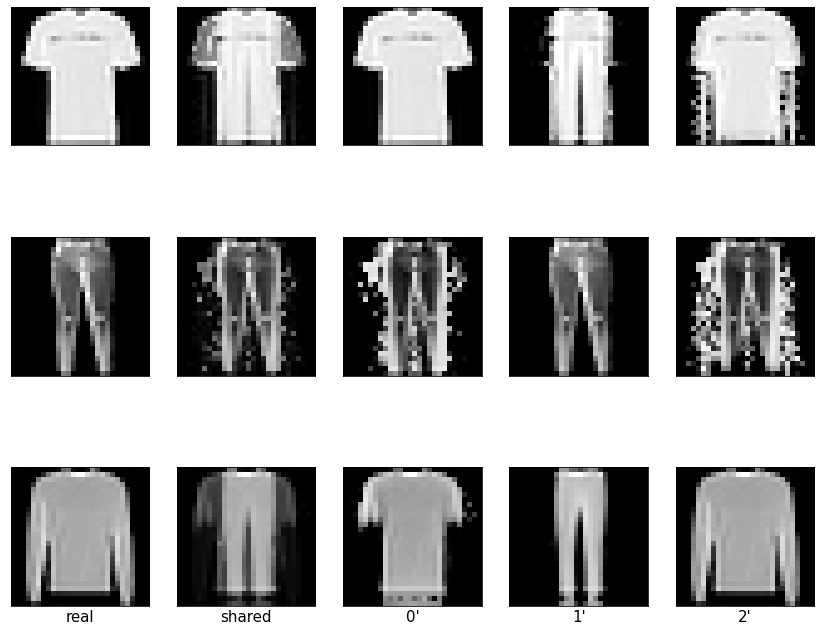

mSWD-NB


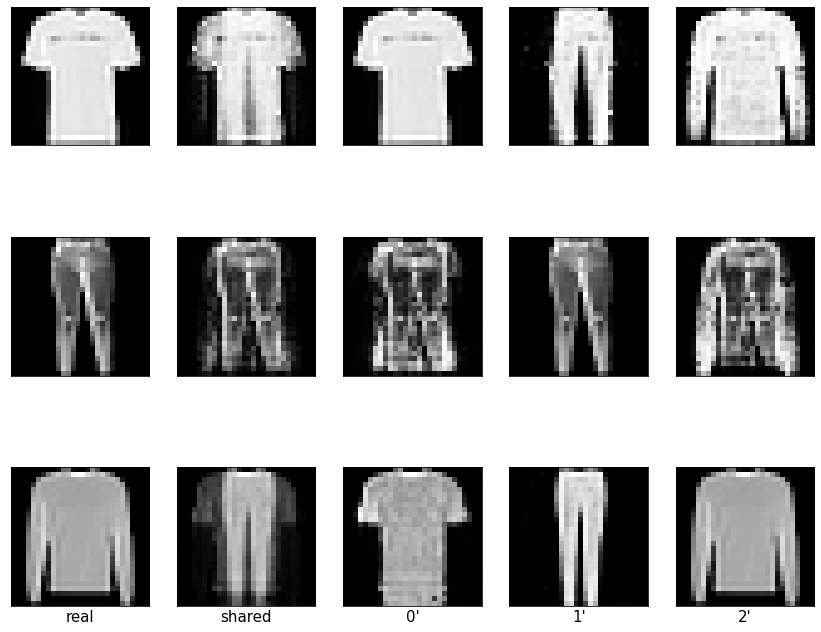

GB


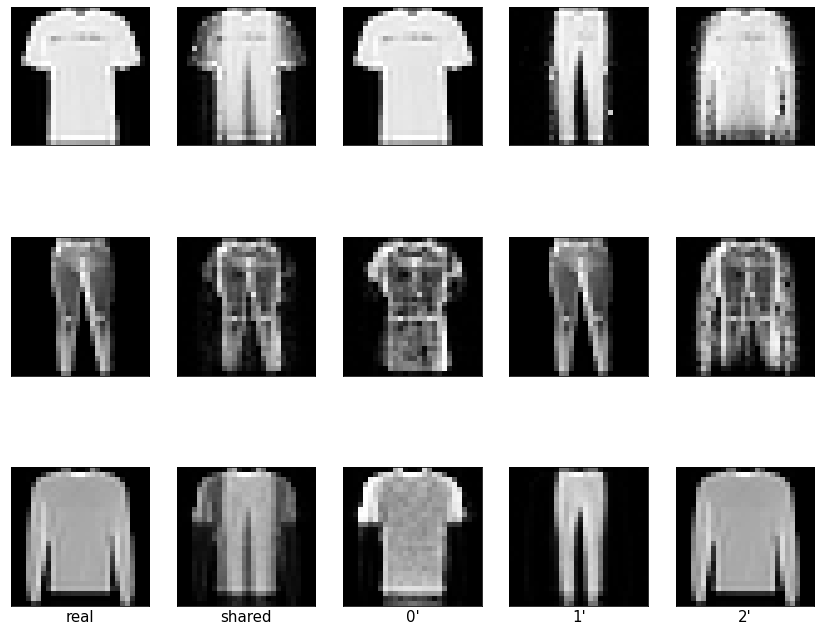

DD


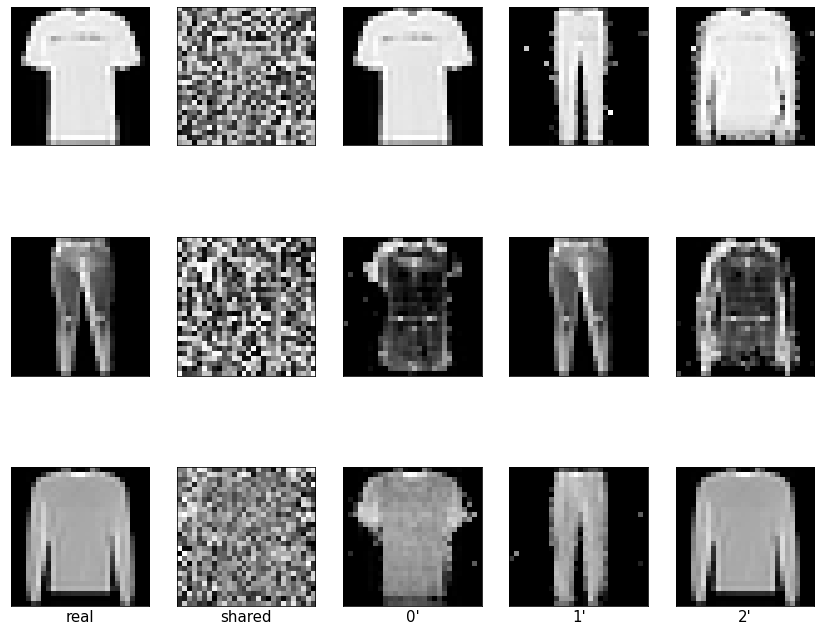

In [16]:
gen_plot(cd_dict,'NB',X,y,'/nb0.png')
gen_plot(cd_dict,'mSWD-NB',X,y,'/swdnb0.png')
gen_plot(cd_dict,'GB',X,y,'/gb0.png')
#gen_plot(cd_dict,'NB',X,y,'/nb0.png')
gen_plot(cd_dict,'DD',X,y,'/dd0.png')

------------------------------------------------------------------------------------------------------
--------------------------------------------------GB--------------------------------------------------
------------------------------------------------------------------------------------------------------


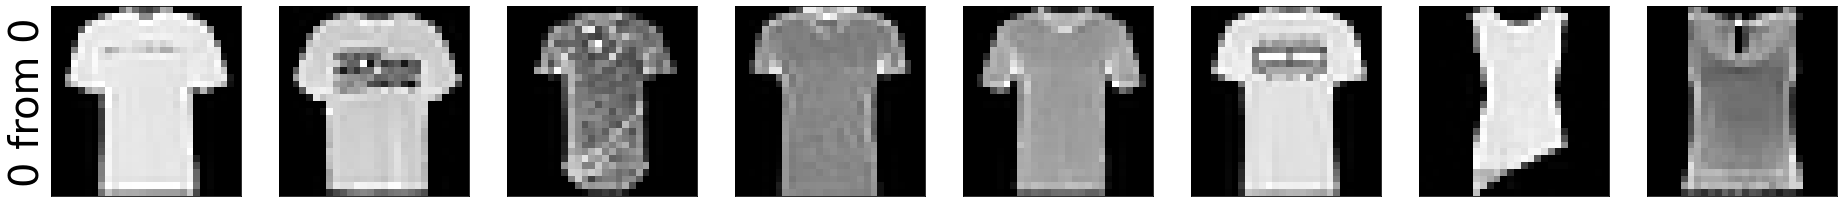

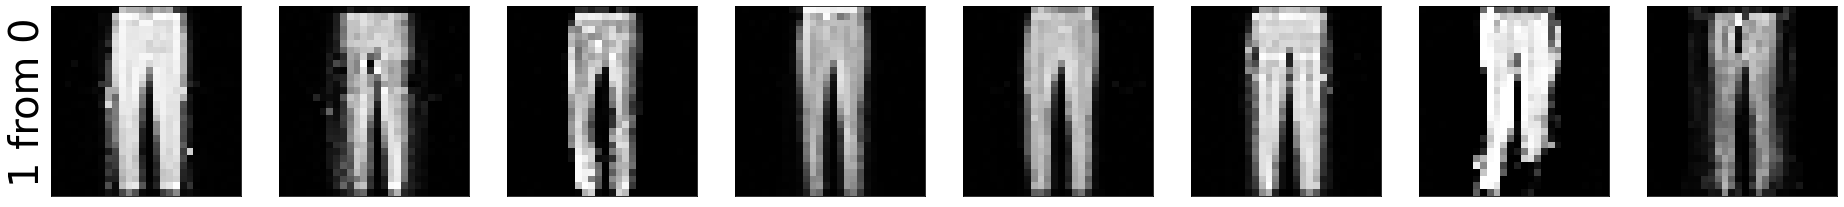

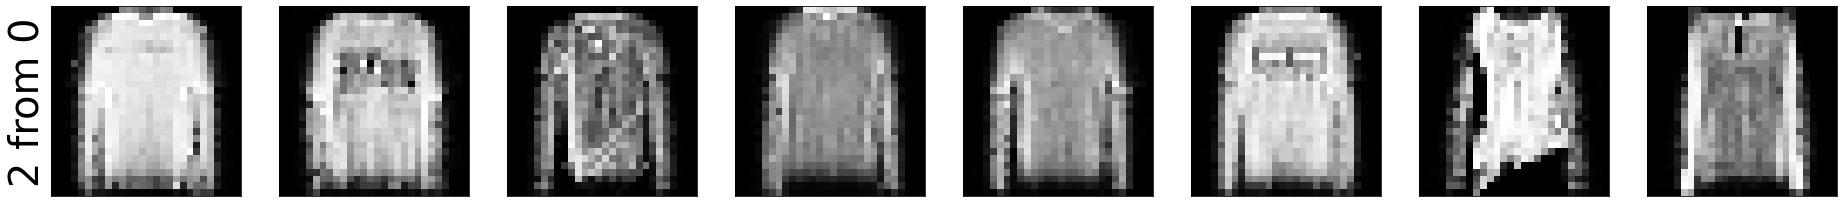

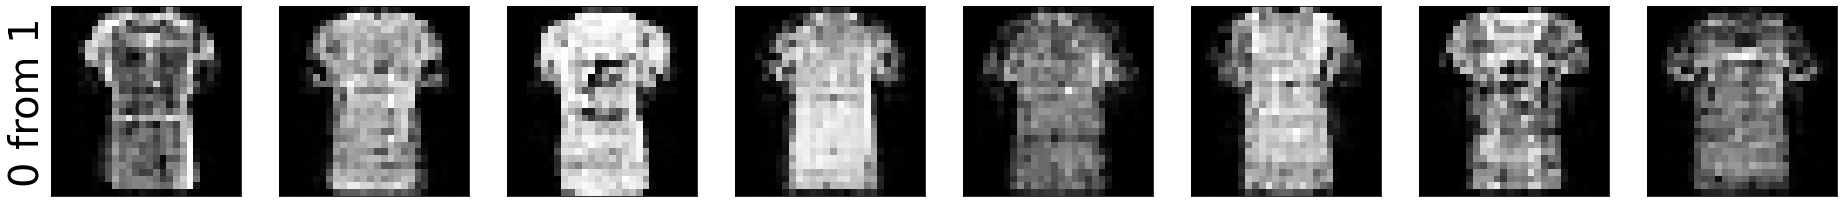

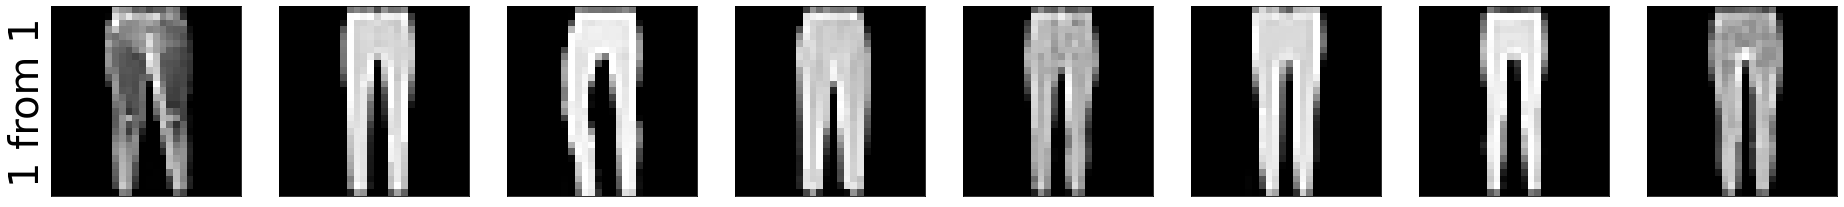

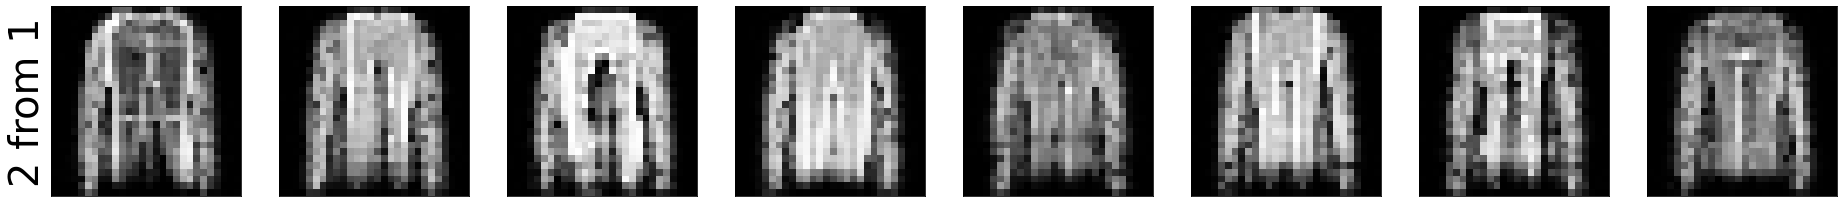

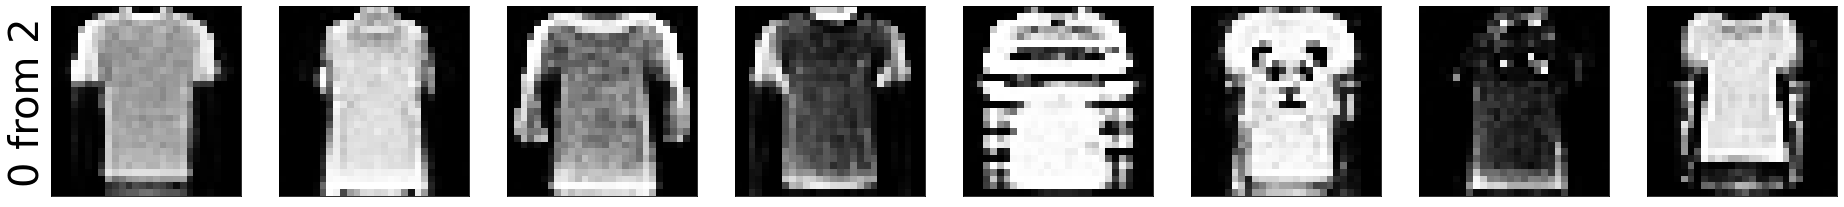

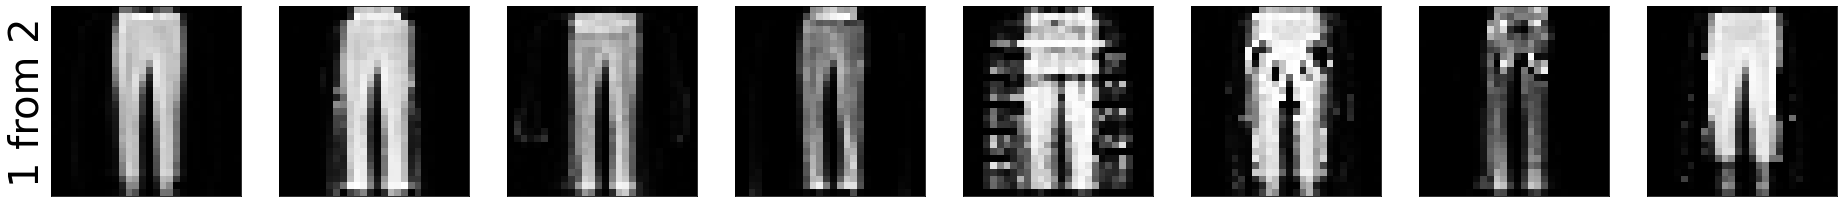

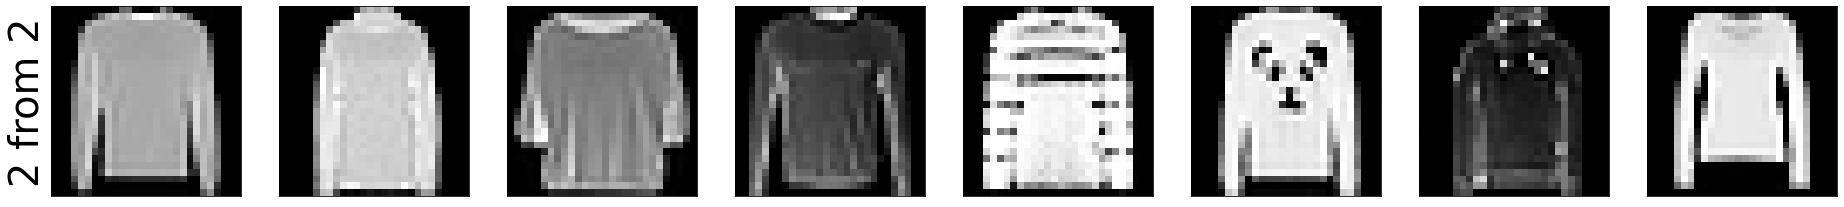

------------------------------------------------------------------------------------------------------
--------------------------------------------------NB--------------------------------------------------
------------------------------------------------------------------------------------------------------


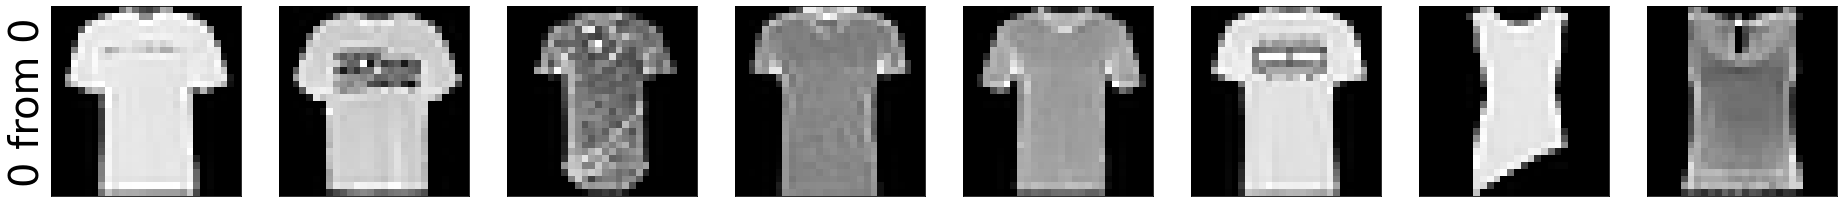

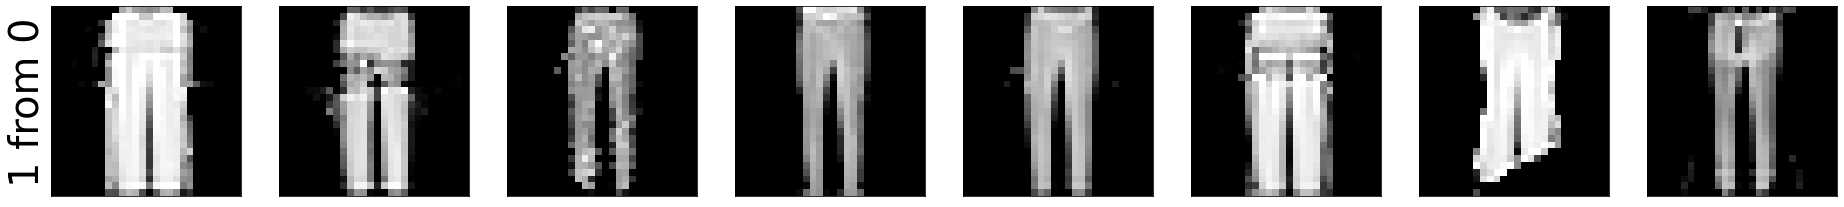

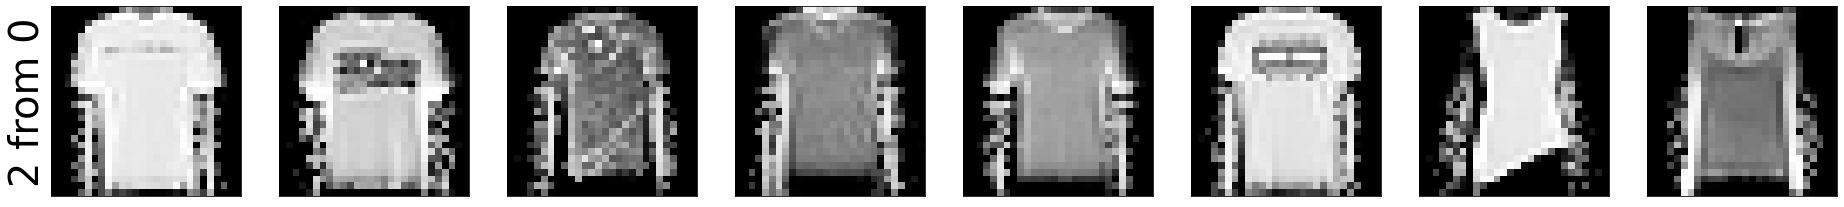

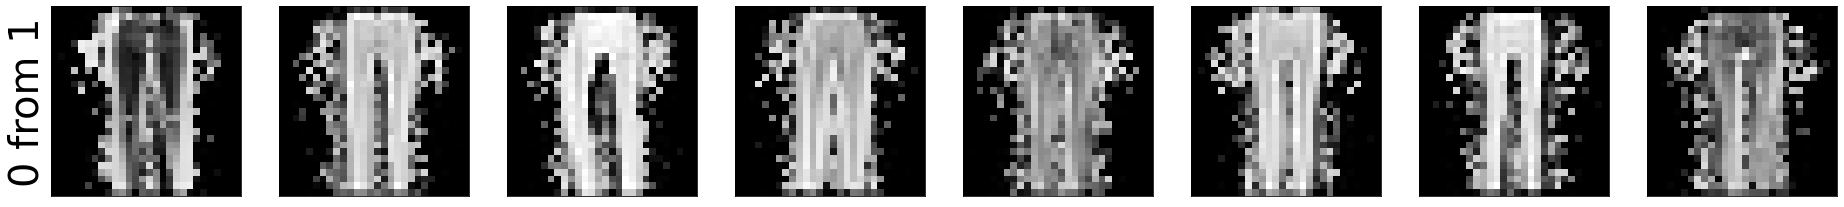

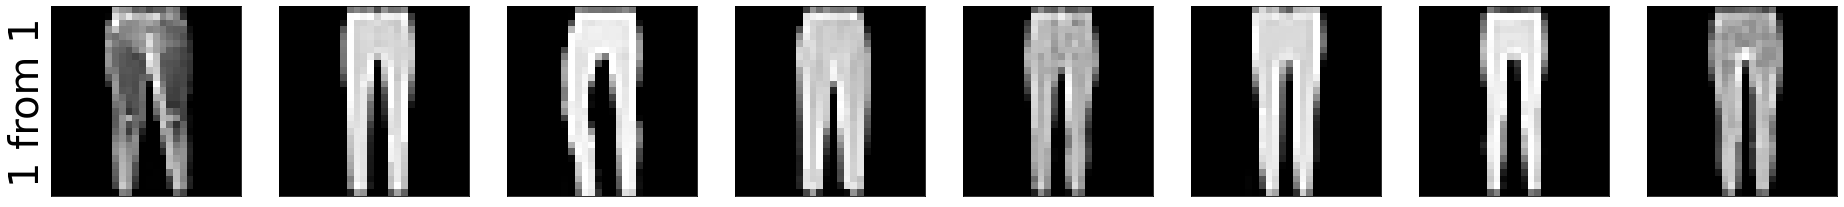

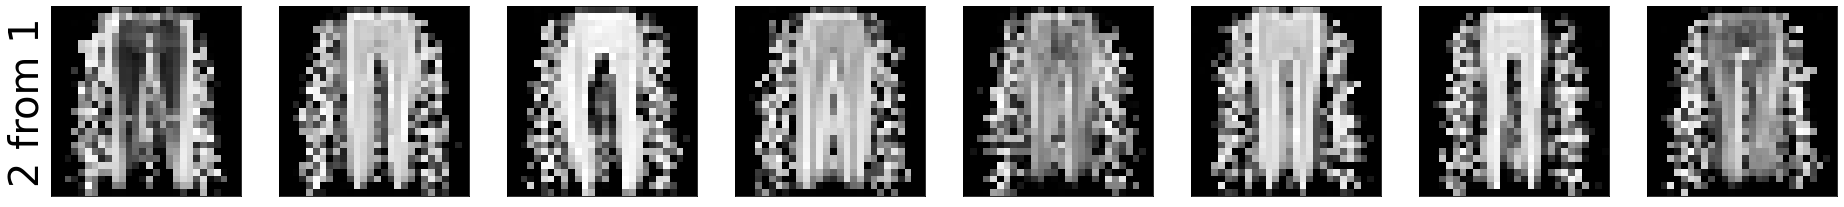

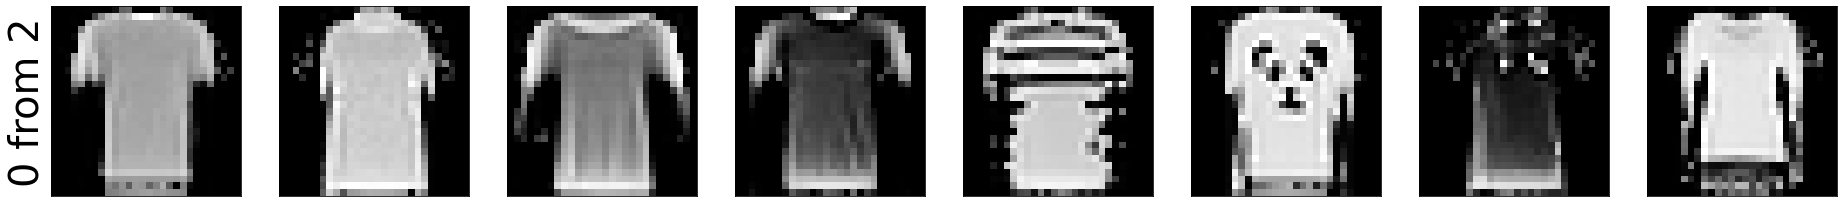

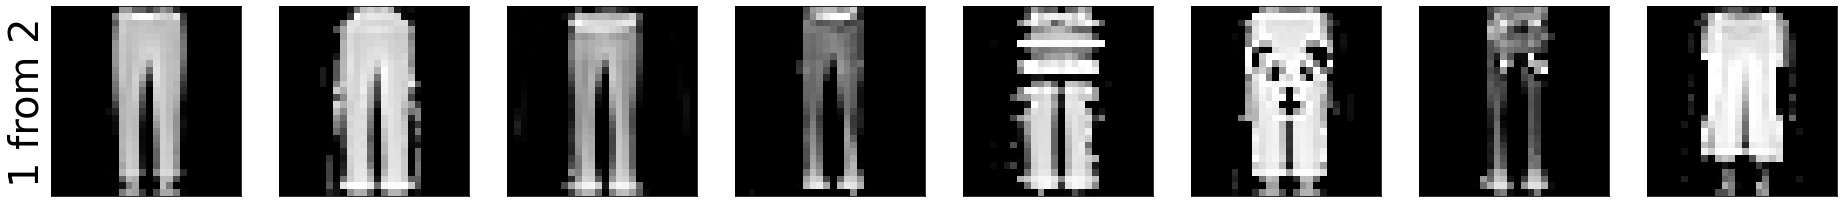

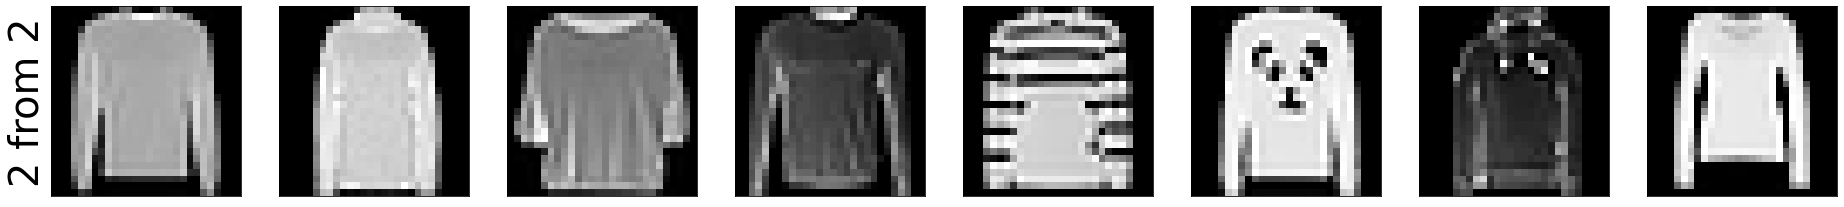

------------------------------------------------------------------------------------------------------
--------------------------------------------------GBNB--------------------------------------------------
------------------------------------------------------------------------------------------------------


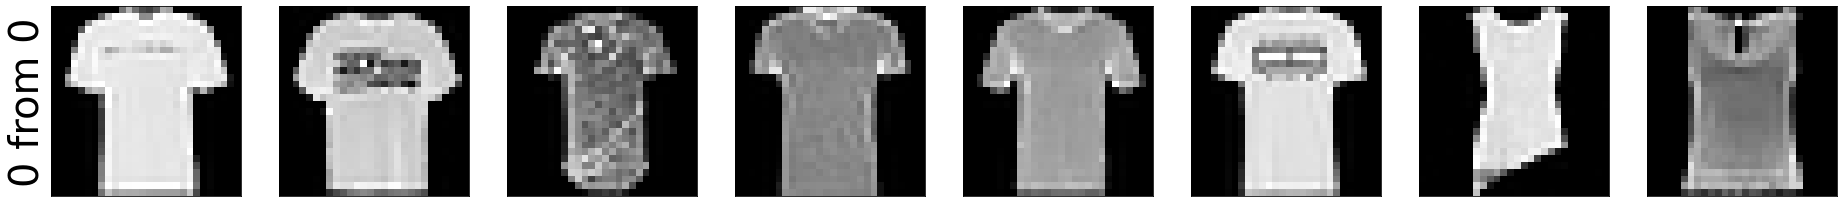

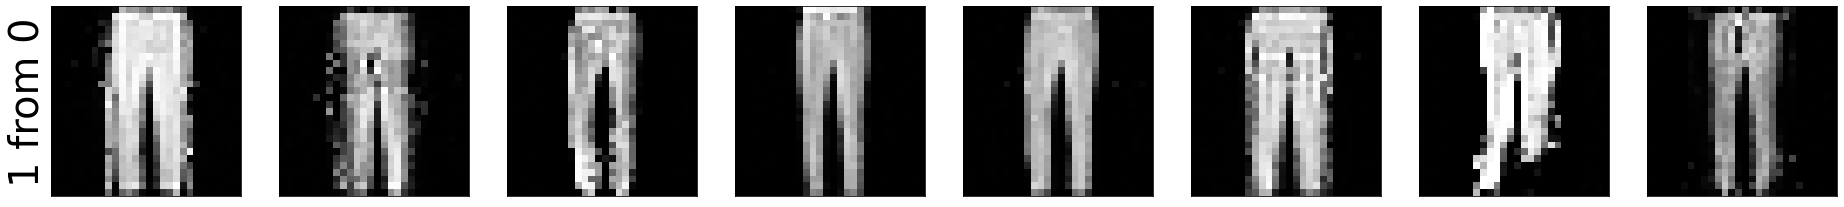

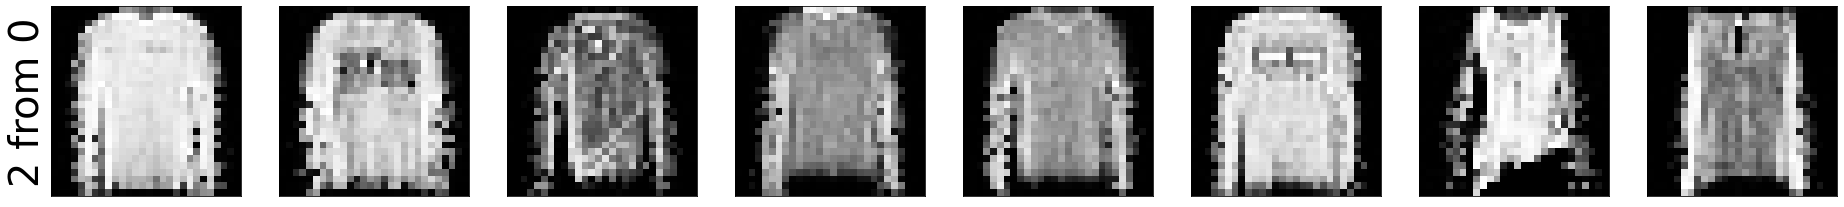

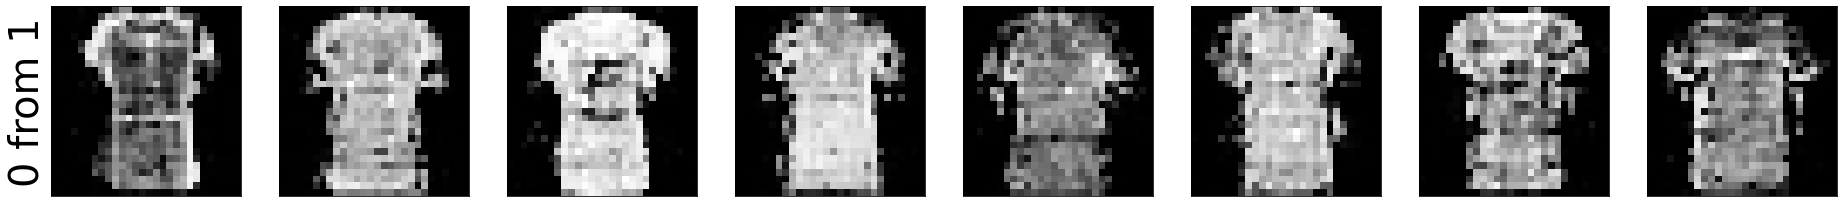

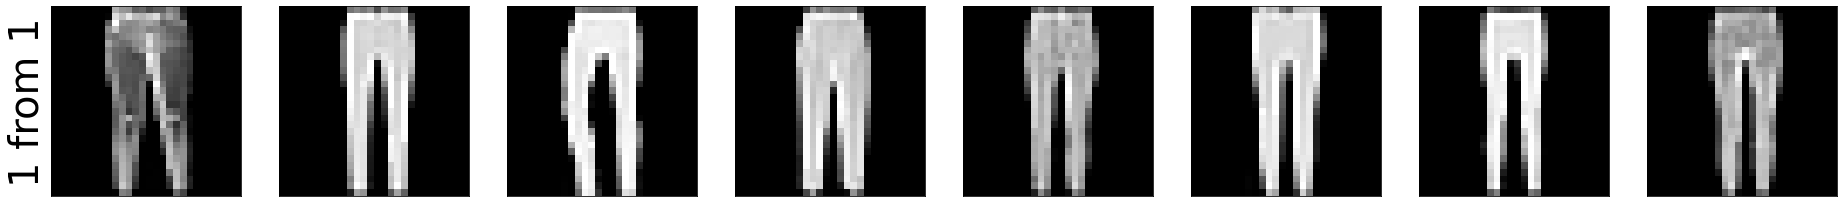

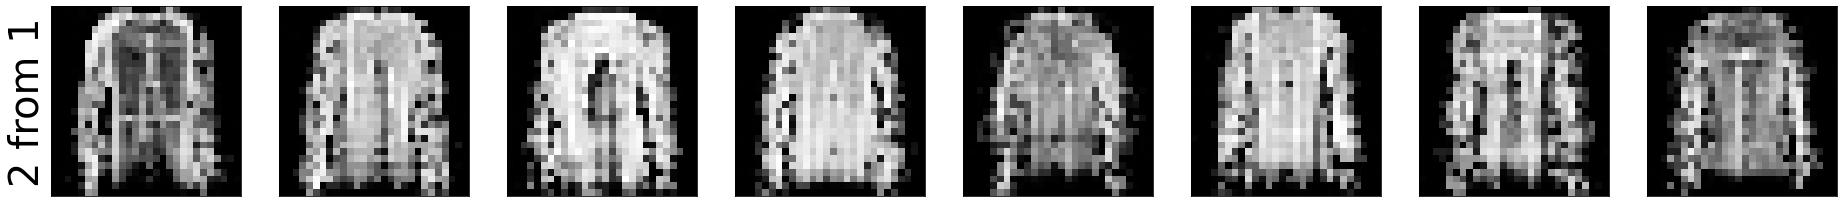

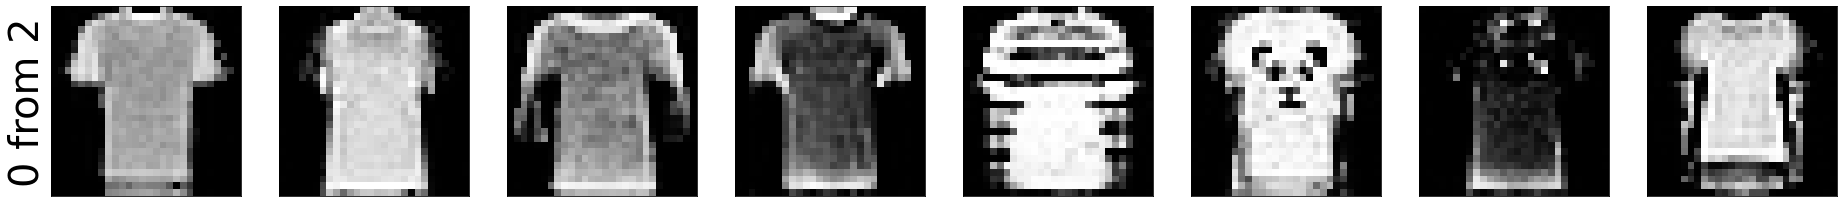

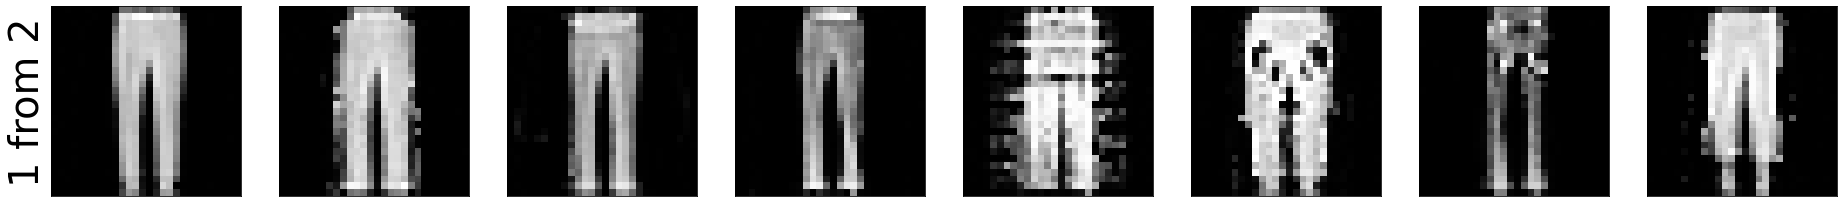

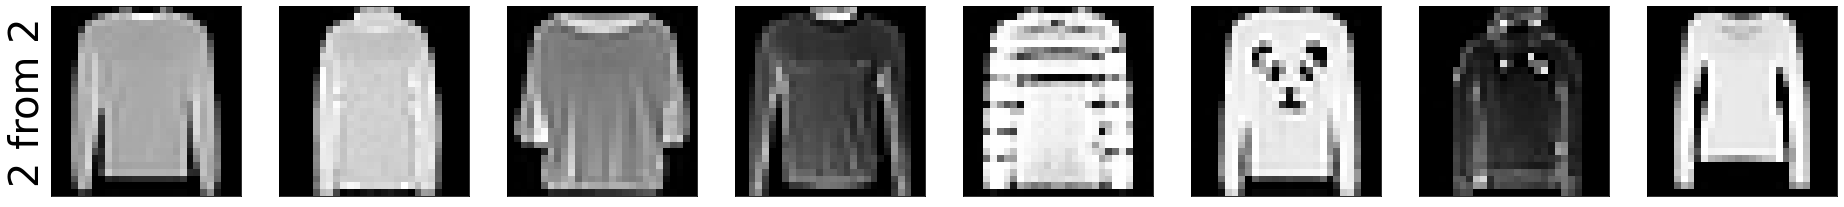

------------------------------------------------------------------------------------------------------
--------------------------------------------------mSWD-NB--------------------------------------------------
------------------------------------------------------------------------------------------------------


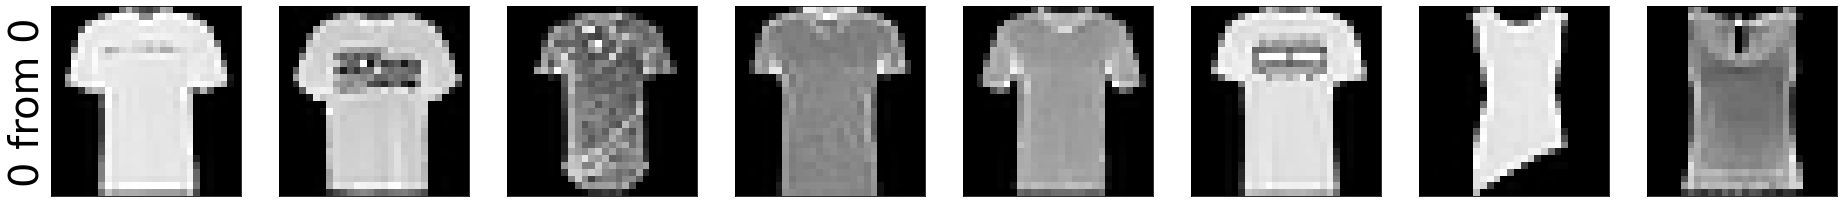

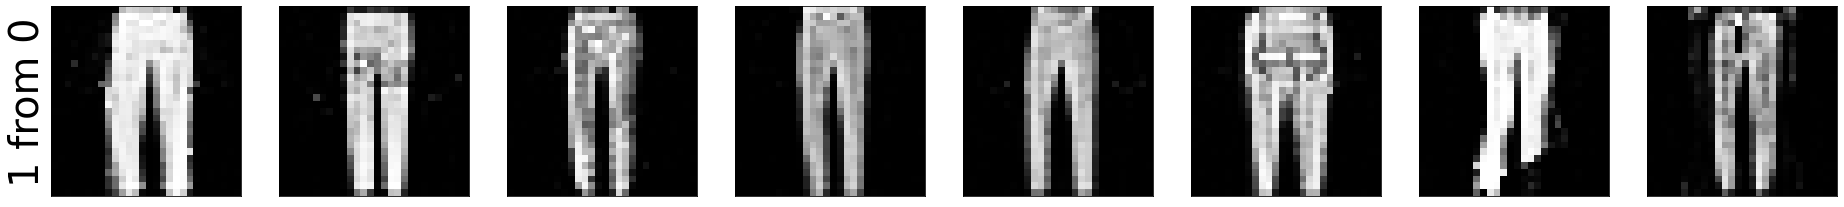

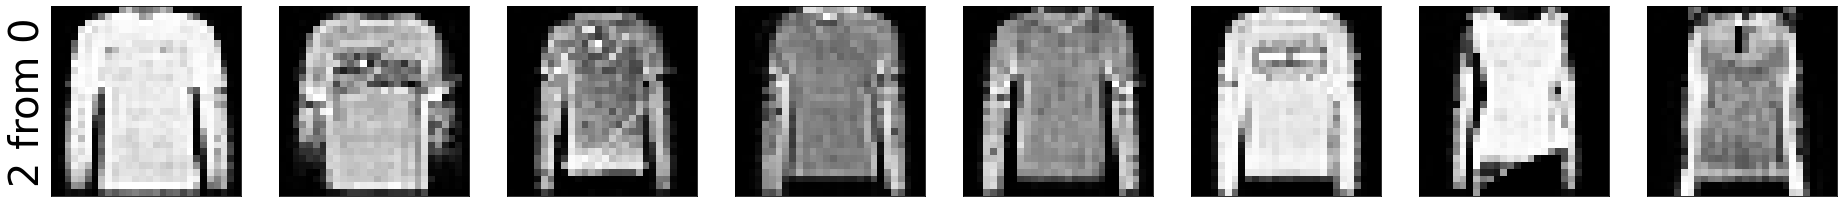

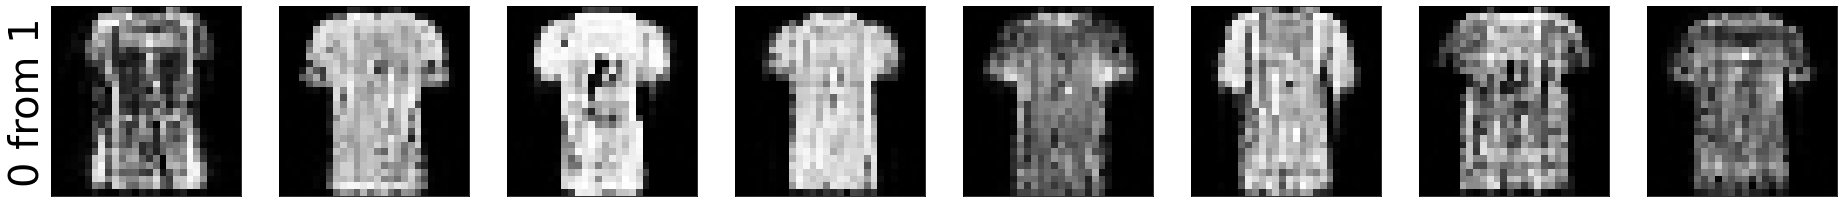

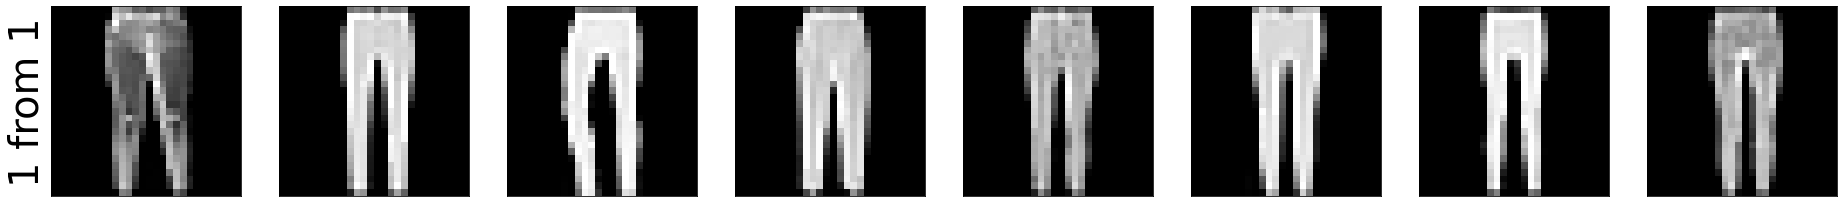

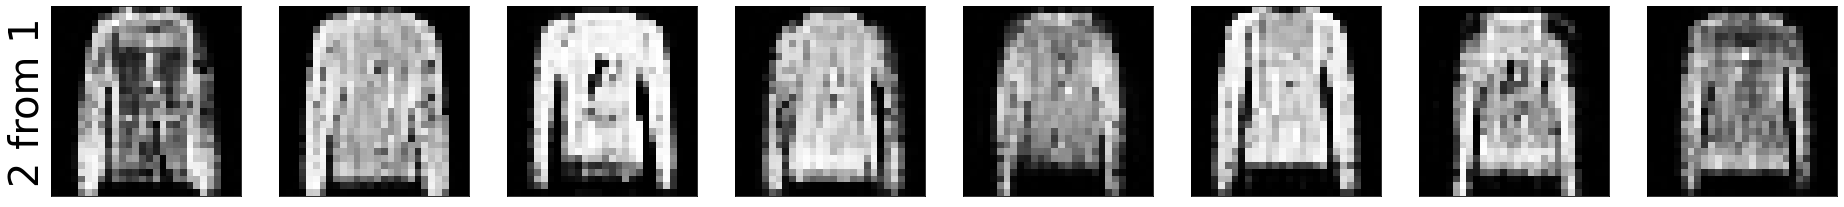

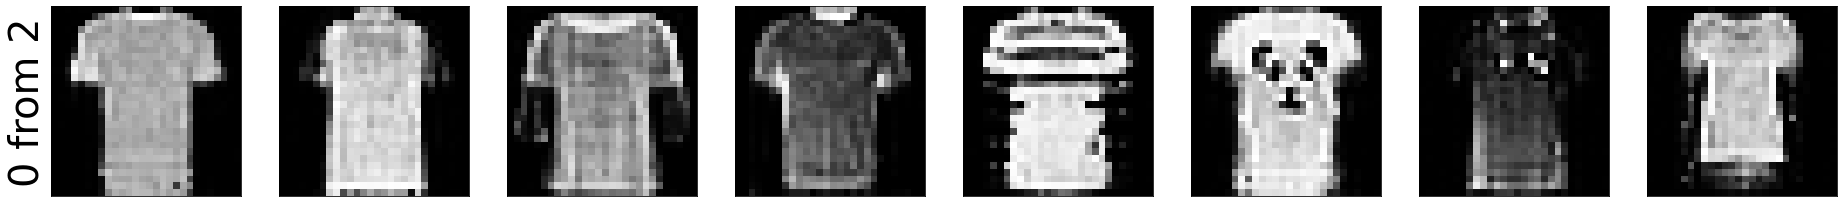

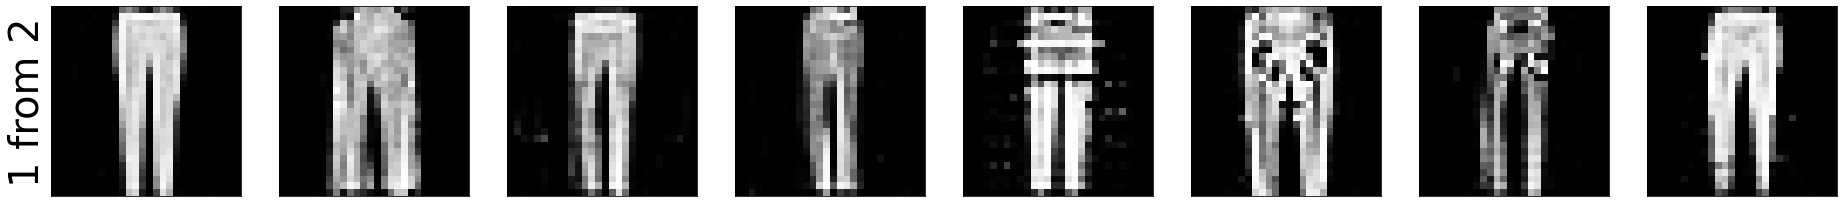

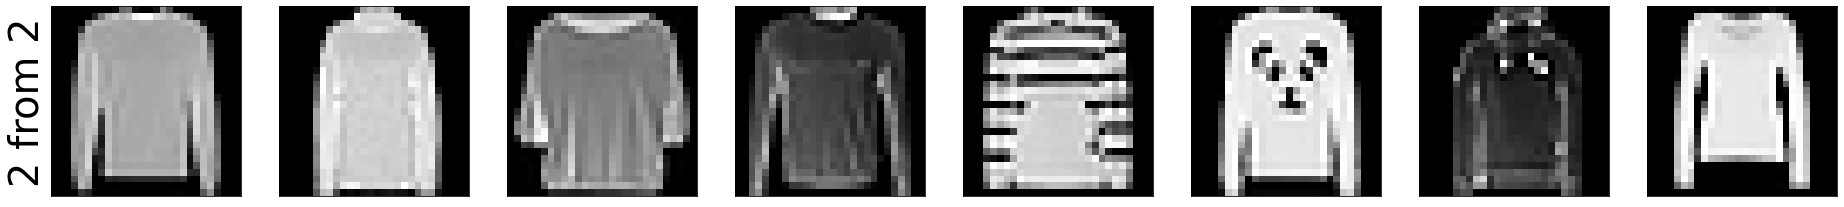

------------------------------------------------------------------------------------------------------
--------------------------------------------------DD--------------------------------------------------
------------------------------------------------------------------------------------------------------


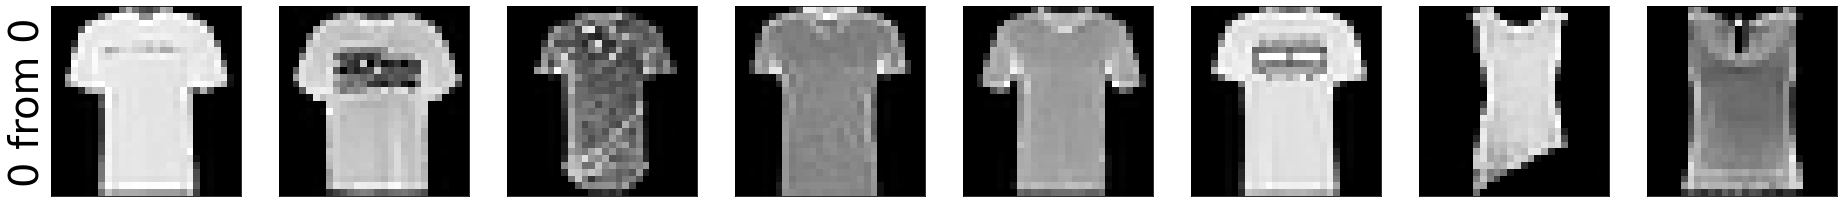

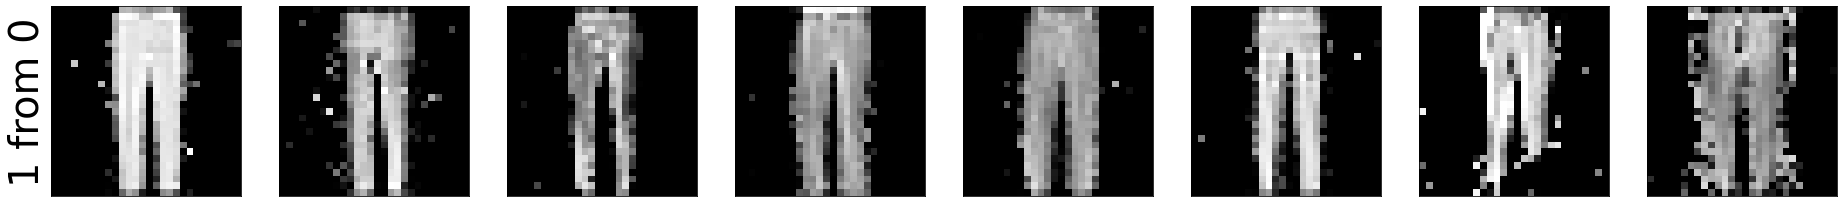

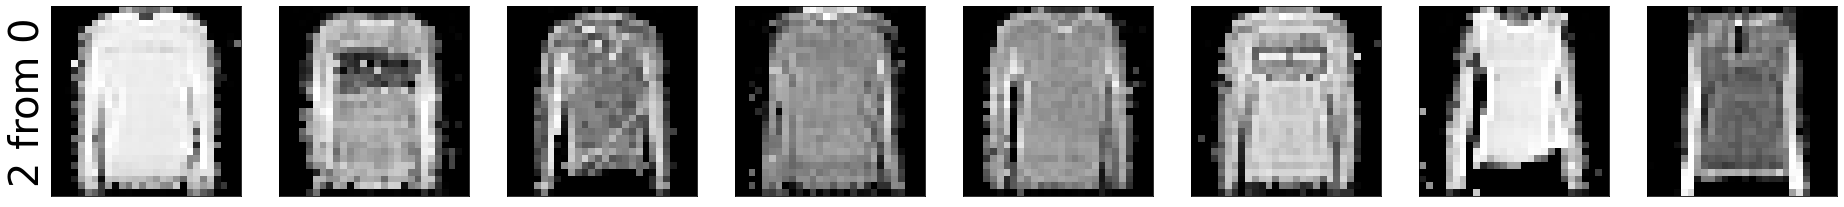

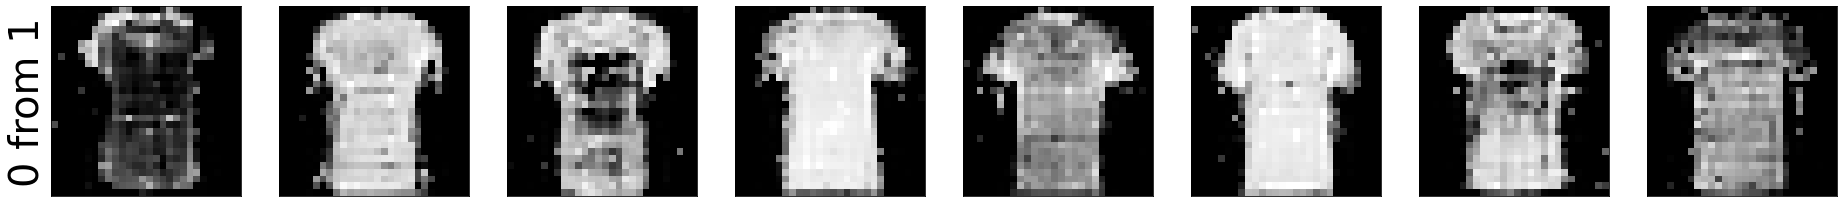

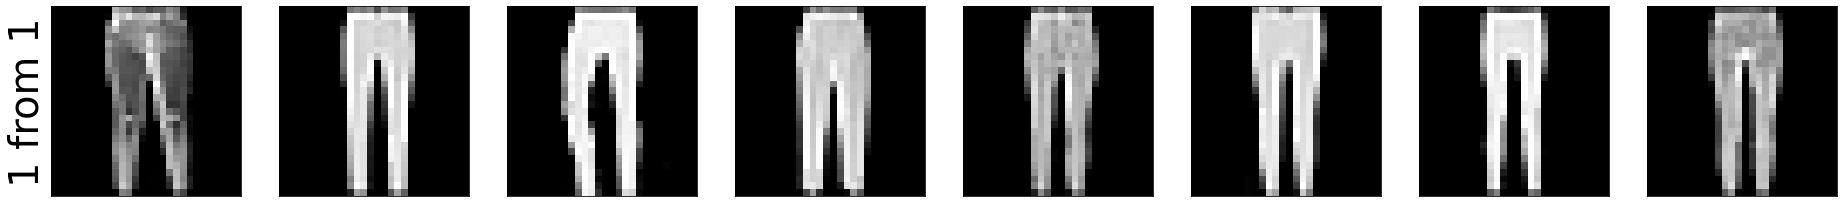

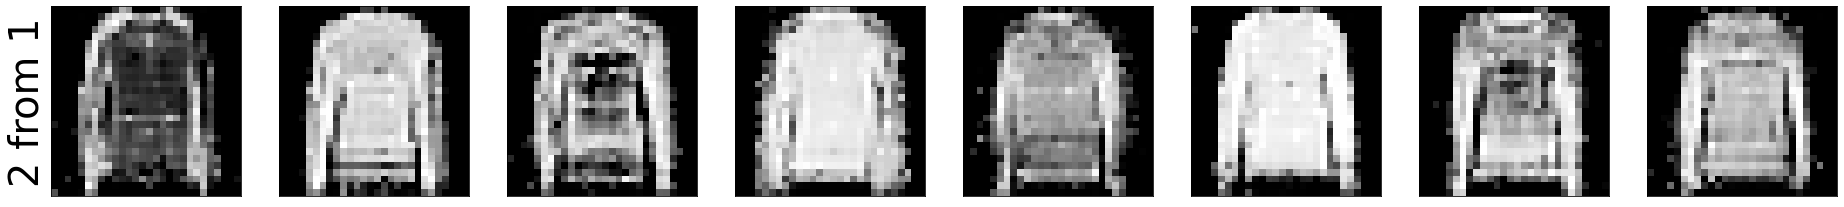

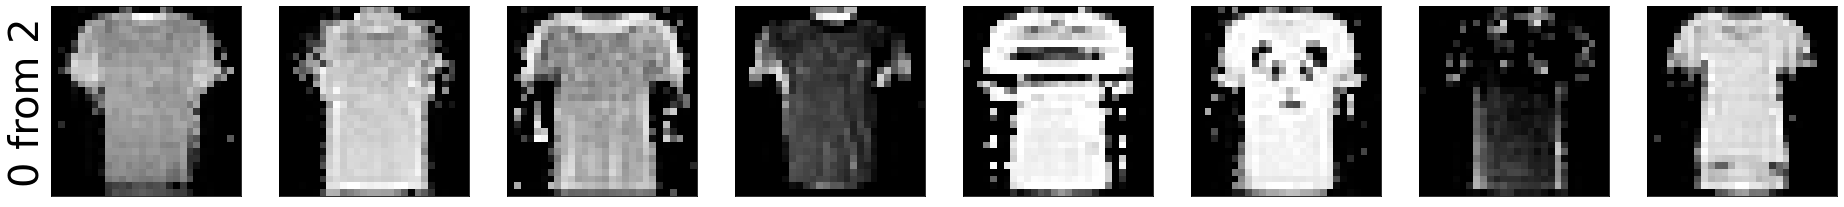

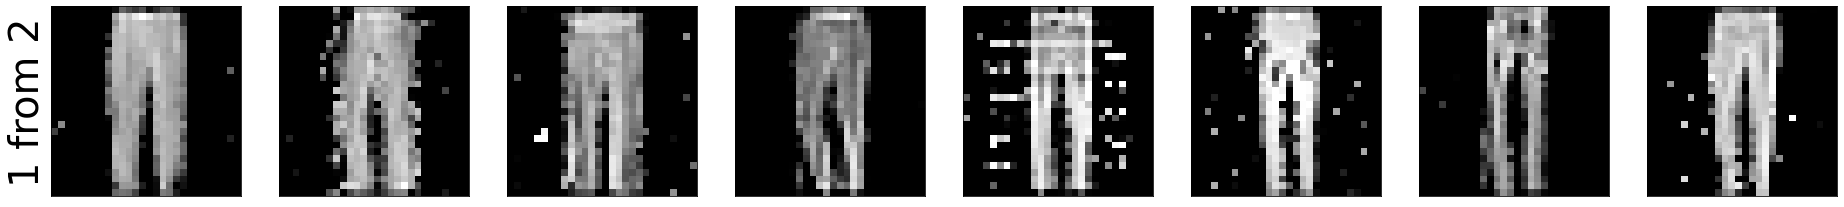

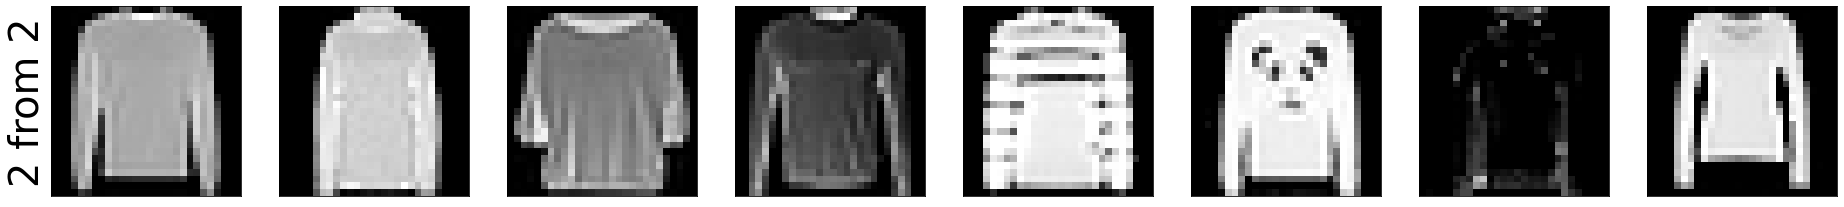

In [17]:
Xflip_dict = dict()

for key, cd, Z_temp in zip(cd_dict.keys(), cd_dict.values(), Z_dict.values()):
    print(102*'-')
    print(50*'-'+key+50*'-')
    print(102*'-')
    
    Xflip_dict_temp = dict()
    for l in class_list:
        
        Z_temp_l_single = Z_temp[np.nonzero(y==l)[0]]
        Z_temp_l = torch.zeros_like(torch.Tensor(Z_temp))
        #Z_temp_l = np.tile(Z_temp_l,(n_class,1))
        for c in class_list:
            Z_temp_l[np.nonzero(y==c)[0]] = torch.Tensor(Z_temp_l_single)
        if key in ['GB', 'NB', 'GBNB','DD']:
            Xflip_temp_l = cd.inverse_transform(Z_temp_l, y)
        else:
            Xflip_temp_l = cd.inverse(Z_temp_l, y)
        
        Xflip_dict_temp[l] = Xflip_temp_l
        for m in class_list:
            idx_temp = np.nonzero(y==m)[0]
            plot_images(1-Xflip_temp_l[idx_temp[:8],: ], ylabel=f'{m} from {l}')
            plt.show()

    Xflip_dict[key] = Xflip_dict_temp

### Transport Cost

transportation cost of GB is 26.38060188293457
transportation cost of NB is 28.233415603637695
transportation cost of GBNB is 31.713397979736328
transportation cost of mSWD-NB is 34.476173400878906
transportation cost of DD is 171.14956665039062


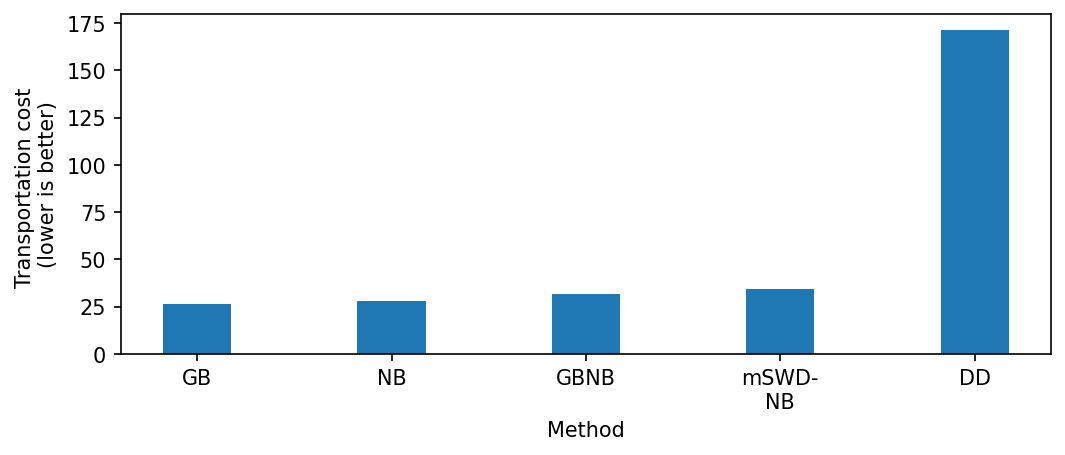

In [18]:
cost_dict = dict()
for key,Z in Z_dict.items():
    cost_temp = transport_cost(X, Z, y)
    cost_dict[key] = cost_temp
    print('transportation cost of '+key+f' is {cost_temp}')
    
fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = ['GB', 'NB', 'GBNB', 'mSWD-\nNB', 'DD']
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(cost_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('Transportation cost \n(lower is better)')
plt.show()

### Empirical WD

In [19]:
def part_wd(X,Xp,partition = 500,norm_var=False,eps=1e-4,max_iter=100):
    sinkhorn = SinkhornDistance(eps=eps, max_iter=max_iter)
    n_samples = X.shape[0]
    idx = 0
    avg_wd = 0
    while idx < n_samples-partition:
        
        avg_wd += partition * sinkhorn(X[idx:idx+partition],Xp[idx:idx+partition])
        idx += partition
    
    partition = n_samples - idx
    avg_wd += partition * sinkhorn(X[idx:idx+partition],Xp[idx:idx+partition])

    if norm_var:
        avg_wd = avg_wd/torch.var(X) 
    
    return avg_wd/n_samples


In [20]:
wd_dict = dict()

for key,Xflip_dict_temp in Xflip_dict.items():

    wd_mat = torch.zeros(len(class_list),len(class_list))

    for idx,l in enumerate(class_list):
        # l - original class
        Xflip_temp_l = Xflip_dict_temp[l]

        for jdx,m in enumerate(class_list):
            # m - fake class
            idx_temp = np.nonzero(y==m)[0]
            X_flip_temp_m = Xflip_temp_l[idx_temp]
            X_real_m = X[idx_temp]
            wd_m_from_l = part_wd(X_real_m,X_flip_temp_m)
            wd_mat[idx,jdx] = wd_m_from_l
    wd_dict[key] = wd_mat


emprical WD of GB is 50.93871307373047
emprical WD of NB is 71.34140014648438
emprical WD of GBNB is 54.04744338989258
emprical WD of mSWD-NB is 42.05876922607422
emprical WD of DD is 44.9752311706543


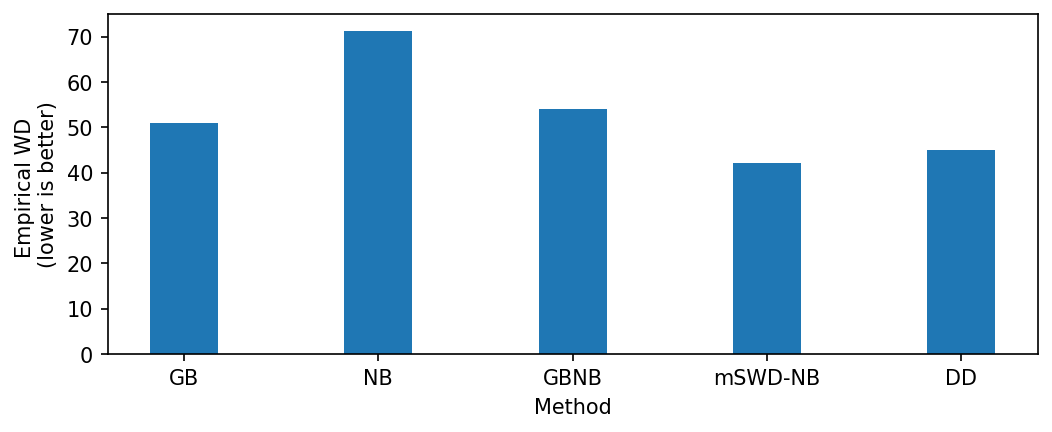

In [21]:
wd_avg_dict = dict()
n_class = len(class_list)
for key,wd_mat in wd_dict.items():
    wd_avg=0
    for idx in range(n_class):
        for jdx in range(n_class):
            if idx!= jdx:
                wd_avg += wd_mat[idx,jdx]
    wd_avg /= (n_class-1)*(n_class-1)
    wd_avg_dict[key] = wd_avg
    print('emprical WD of '+key+ f' is {wd_avg}')

fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = list(wd_dict.keys())
x_axis = np.arange(len(labels))
wd_list = [wd_avg for wd_avg in list(wd_avg_dict.values())]
ax.bar(x_axis, wd_list, 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('Empirical WD \n(lower is better)')
plt.show()

### FID

In [22]:
import sys
sys.path.append('')

In [23]:
from fid_score import evaluate_fid_score

In [24]:
#evaluate_fid_score(torch.Tensor(X)[y==1].float().reshape(torch.Tensor(X)[y==1].shape[0],28,28,1), torch.Tensor(X)[y==0].float().reshape(torch.Tensor(X)[y==0].shape[0],28,28,1))

In [ ]:
fid_dict = dict()

for key,Xflip_dict_temp in Xflip_dict.items():
    print(key)
    
    fid_mat = torch.zeros(len(class_list),len(class_list))

    for idx,l in enumerate(class_list):
        # l - original class
        Xflip_temp_l = Xflip_dict_temp[l] # all digits transformed from class l

        for jdx,m in enumerate(class_list):
            # m - fake class
            idx_temp = np.nonzero(y==m)[0]
            X_flip_temp_m = Xflip_temp_l[idx_temp]
            X_real_m = X[idx_temp]
            
            # Preprocess
            X_real_m = torch.Tensor(X_real_m)
            X_real_m = X_real_m.reshape(X_real_m.shape[0],28,28,1)
            X_flip_temp_m = torch.Tensor(X_flip_temp_m)
            X_flip_temp_m = X_flip_temp_m.reshape(X_flip_temp_m.shape[0],28,28,1)
            
            # compute FID
            fid_m_from_l = evaluate_fid_score(X_real_m,X_flip_temp_m)
            fid_mat[idx,jdx] = fid_m_from_l
    fid_dict[key] = fid_mat

FID of GB is 143.6279754638672
FID of NB is 166.11354064941406
FID of GBNB is 160.9453887939453
FID of mSWD-NB is 117.12615966796875
FID of DD is 131.0433349609375


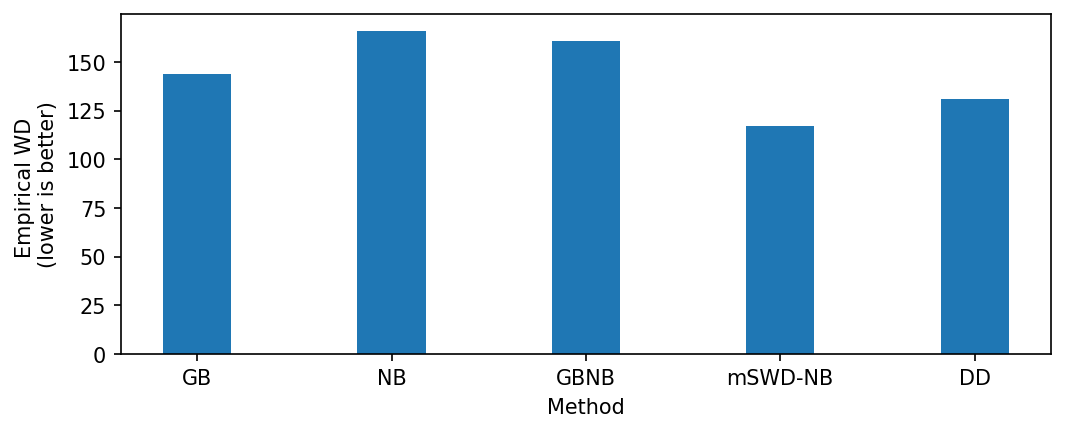

In [26]:
fid_avg_dict = dict()
n_class = len(class_list)
for key,fid_mat in fid_dict.items():
    fid_avg=0
    for idx in range(n_class):
        for jdx in range(n_class):
            if idx!= jdx:
                fid_avg += fid_mat[idx,jdx]
    fid_avg /= (n_class-1)*(n_class-1)
    fid_avg_dict[key] = fid_avg
    print('FID of '+key+ f' is {fid_avg}')

fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = list(wd_dict.keys())
x_axis = np.arange(len(labels))
wd_list = [fid_avg for fid_avg in list(fid_avg_dict.values())]
ax.bar(x_axis, wd_list, 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('Empirical WD \n(lower is better)')
plt.show()

In [27]:
for key, wd_mat in wd_dict.items():
    print('###########')
    print(key)
    print('###########')
    print(wd_mat)

###########
GB
###########
tensor([[ 0.5144, 19.2856, 38.7202],
        [34.7493,  0.2305, 41.7466],
        [44.4381, 24.8150,  0.4102]])
###########
NB
###########
tensor([[1.4477e-02, 3.2163e+01, 4.6819e+01],
        [5.7124e+01, 3.7775e-02, 6.9011e+01],
        [4.2060e+01, 3.8190e+01, 2.4869e-03]])
###########
GBNB
###########
tensor([[ 0.5259, 20.6502, 42.6952],
        [41.1972,  0.2680, 48.4551],
        [39.3386, 23.8534,  0.4317]])
###########
mSWD-NB
###########
tensor([[ 0.2117, 18.5622, 33.0757],
        [32.1533,  0.7984, 34.7626],
        [31.3329, 18.3484,  0.0877]])
###########
DD
###########
tensor([[ 2.0060, 22.1630, 32.9445],
        [34.4556,  0.6505, 34.8667],
        [33.3722, 22.0989,  2.2727]])


In [28]:
for key, fid_mat in fid_dict.items():
    print('###########')
    print(key)
    print('###########')
    print(fid_mat)

###########
GB
###########
tensor([[  0.7388,  34.0651, 112.3578],
        [114.1301,   0.6909, 161.4496],
        [ 87.4625,  65.0467,   0.8872]])
###########
NB
###########
tensor([[3.5770e-02, 5.3329e+01, 9.2730e+01],
        [1.8478e+02, 1.5629e-01, 1.9931e+02],
        [6.6345e+01, 6.7965e+01, 8.3898e-03]])
###########
GBNB
###########
tensor([[  0.7195,  36.0926, 137.3092],
        [143.4815,   0.7884, 207.9288],
        [ 69.7674,  49.2021,   0.8742]])
###########
mSWD-NB
###########
tensor([[  0.6907,  38.7643,  78.7864],
        [106.1443,   1.7296, 136.6511],
        [ 71.1193,  37.0392,   0.4159]])
###########
DD
###########
tensor([[  2.3359,  70.4240,  82.1130],
        [107.0020,   1.7452, 120.9111],
        [ 75.4325,  68.2907,   2.9922]])


In [29]:
import pickle
def save_obj(obj, name ):
    with open(''+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [30]:
save_obj(wd_dict,'exp1/wd')

In [31]:
save_obj(fid_dict,'exp1/fid')

### FID (Saving)

In [33]:
# saving_digit = True

In [34]:
# root_dir = ''

In [35]:
# from torchvision import utils as vutils
 
# def save_image_tensor(input_tensor: torch.Tensor, filename):
#     """
#          Save tensor as picture
#          :param input_tensor: tensor to save
#          :param filename: saved file name
#     """
#     assert (len(input_tensor.shape) == 4 and input_tensor.shape[0] == 1)
#          # Make a copy
#     input_tensor = input_tensor.clone().detach()
#          # To cpu
#     input_tensor = input_tensor.to(torch.device('cpu'))
#          # Denormalization
#     # input_tensor = unnormalize(input_tensor)
#     vutils.save_image(input_tensor,filename)

In [36]:
# # saving real data

# if saving_digit:

#     real_dir = os.path.join(root_dir, 'real')
#     for c in class_list:
#         class_dir = os.path.join(real_dir,f'{c}')
#         X_c = torch.Tensor(X)[y==c]
#         if not os.path.exists(class_dir):
#             os.makedirs(class_dir)
#         for i in range(X_c.shape[0]):
#             x_temp = X_c[i,:].view(1,1,28,28)
#             save_image_tensor(x_temp,os.path.join(class_dir,f'{i}.png'))

#     # saving other data

#     for key,Xflip_dict_temp in Xflip_dict.items():

#         model_dir = os.path.join(root_dir,key)
#         for c in class_list:
#             class_dir = os.path.join(model_dir,f'{c}')
#             for m in class_list:
#                 class_m_dir = os.path.join(class_dir,f'{m}')
#                 X_c = torch.Tensor(Xflip_dict_temp[c])[np.nonzero(y==m)[0]]
#                 if not os.path.exists(class_m_dir):
#                     os.makedirs(class_m_dir)
        
#                 for i in range(X_c.shape[0]):
#                     x_temp = X_c[i,:].view(1,1,28,28)
#                     save_image_tensor(x_temp,os.path.join(class_m_dir,f'{i}.png'))
